# Prolog

In [209]:
import pandas as pd
import seaborn as sb
import os
import OHCParser as op
import datetime
import traceback
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
import matplotlib
import numpy as np
import pathlib

## Auxiliary methods

In [210]:
# Secondary x-axis for cells per core
def addSecondaryAxisCellsPerCore(ax, cellsNumber):
    ticksCellsPerCoreInT = [round(cellsNumber/n/1000, 1) for n in ax.get_xticks()]
    tickLabelsStr = [f'{val:.0f}' if val%1 < 1e-1 else f'{val:.1f}' \
            for val in ticksCellsPerCoreInT]
    ax2 = ax.twiny()
    labelFontSize = 7

    ax2.set_xscale("log")
    ax2.set_xticks(ax.get_xticks())
    ax2.set_xticklabels(tickLabelsStr, fontsize=labelFontSize)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xlabel("Number of Cells per Core in thousands")
    ax2.tick_params(axis='x', which='both', labelrotation=90)

    formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 1))
    ax2.xaxis.set_minor_formatter(formatter)
    ticksCellsPerCoreInT = [round(cellsNumber/n/1000, 1) for n in ax.get_xticks(minor=True)]
    tickLabelsStr = [f'{val:.0f}' if val%1 < 1e-1 else f'{val:.1f}' \
             for val in ticksCellsPerCoreInT]
    ax2.set_xticks(ax.get_xticks(minor=True), minor=True)
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticklabels(tickLabelsStr, minor=True, fontsize=labelFontSize)



## Read Data

In [211]:
# general data
size_coarse=65e6
size_medium=110e6
size_fine=236e6

dfs = op.read_submissions()
dfs = op.derive_metrics(dfs)

# provide filtered data
df_hardware = dfs[dfs["Track"] == "Hardware Track"]
df_hardware = df_hardware.sort_values("CPU Family")
df_software = dfs[dfs["Track"] == "Software Track"]
df_hw_coarse = df_hardware[df_hardware["Mesh"]=="coarse"]
df_hw_medium = df_hardware[df_hardware["Mesh"]=="medium"]
df_hw_fine = df_hardware[df_hardware["Mesh"]=="fine"]

fig_folder = "figures_hwtrack"
doSaveFig = False

last time the data was updated 2025-09-05 13:41:09.178880  by  sles
03_OHC1_DrivAer_Result_Template_v3 Ruggero Poletto.xlsm: No energy data found


/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/sles/.venvs/py3.12/lib/python3.12/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


10_Olenik_OHC1_FTP_S_MILAN250_CPU.xlsm: No energy data found
08_OHC1_DrivAer_Result_inductiva_65M Gabriel Marcos Magalhães.xlsm: No energy data found
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: number of timestep != number of wall clock time, assuming partial run
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: trying to fill wct, this makes only sense if N/A cases are contiguously to the right at the moment
05_Huawei_OHC1_DrivAer_Result_Software_MxP_Fine.xlsm: No energy data found


# Overview

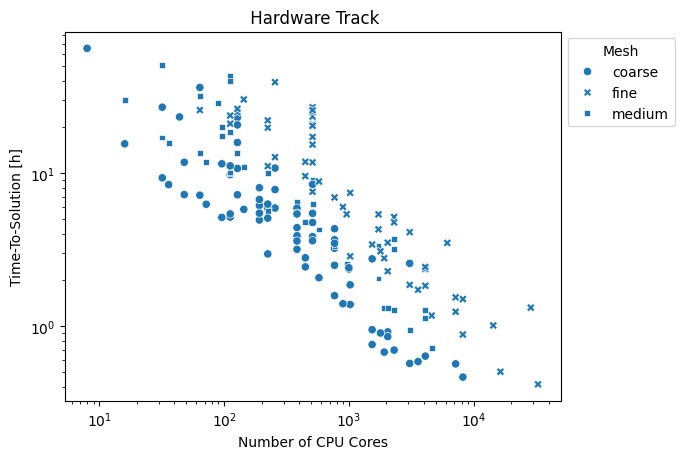

In [212]:
ax = sb.scatterplot(df_hardware,x="Number of CPU Cores", y="Time-To-Solution [h]", style="Mesh")
ax.set(xscale="log", yscale="log", title=" Hardware Track")
ax.set(ylabel="Time-To-Solution [h]")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "submissions_overview", doSaveFig)

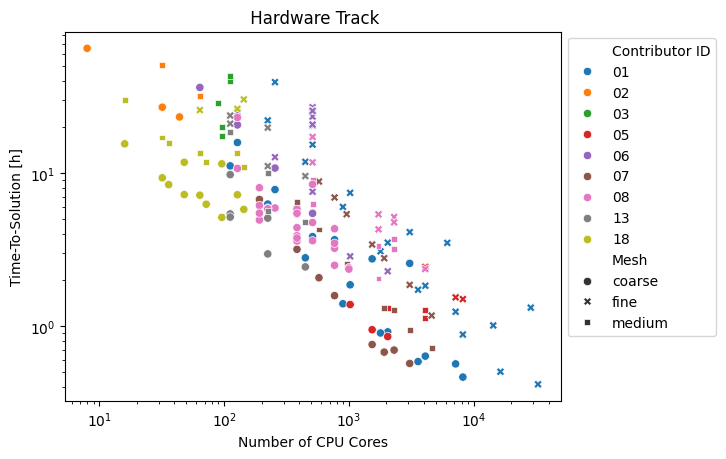

In [213]:
ax = sb.scatterplot(df_hardware.sort_values("Contributor ID"),x="Number of CPU Cores", y="Time-To-Solution [h]", hue="Contributor ID", style="Mesh")
ax.set(xscale="log", yscale="log", title=" Hardware Track")
ax.set(ylabel="Time-To-Solution [h]")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "wct_cores_mesh", doSaveFig)

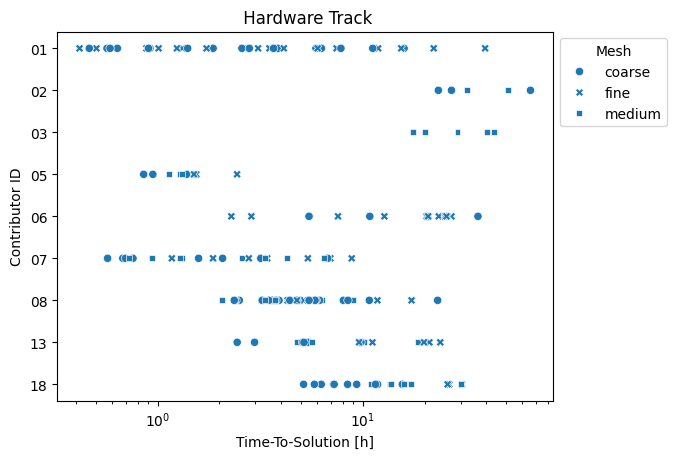

In [214]:

ax = sb.scatterplot(df_hardware.sort_values("Contributor ID"),y="Contributor ID", x="Time-To-Solution [h]", style="Mesh")
ax.set(xscale="log", title=" Hardware Track")
ax.set(xlabel="Time-To-Solution [h]")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()

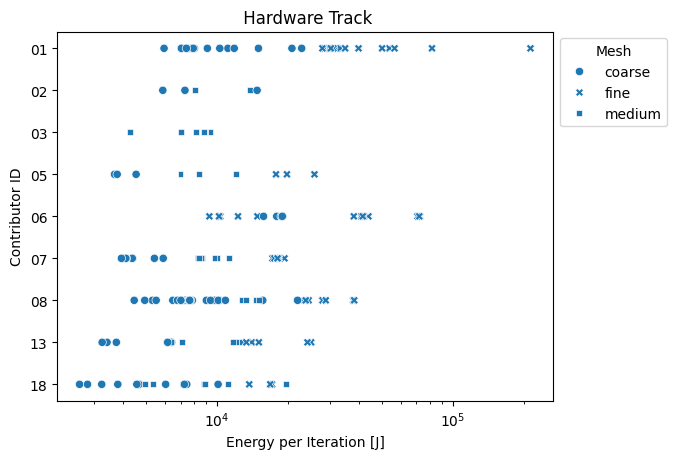

In [215]:

ax = sb.scatterplot(df_hardware.sort_values("Contributor ID"),y="Contributor ID", x="Energy per Iteration [J]", style="Mesh")
ax.set(xscale="log", title=" Hardware Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()

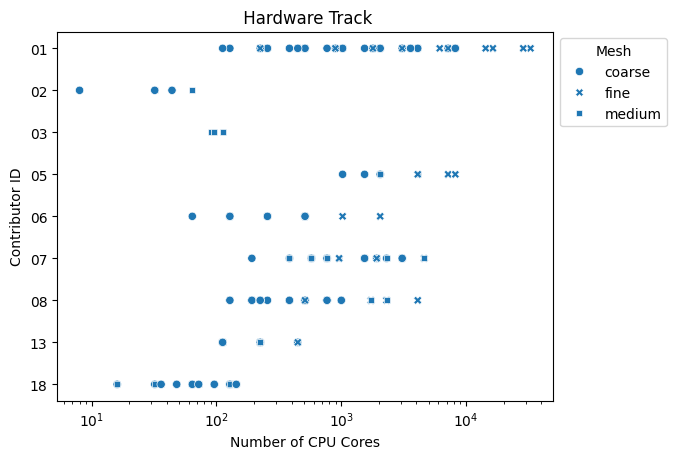

In [216]:

ax = sb.scatterplot(df_hardware.sort_values("Contributor ID"),y="Contributor ID", x="Number of CPU Cores", style="Mesh")
ax.set(xscale="log", title=" Hardware Track")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "cores_contributor", doSaveFig)

# Performance WCT & Energy

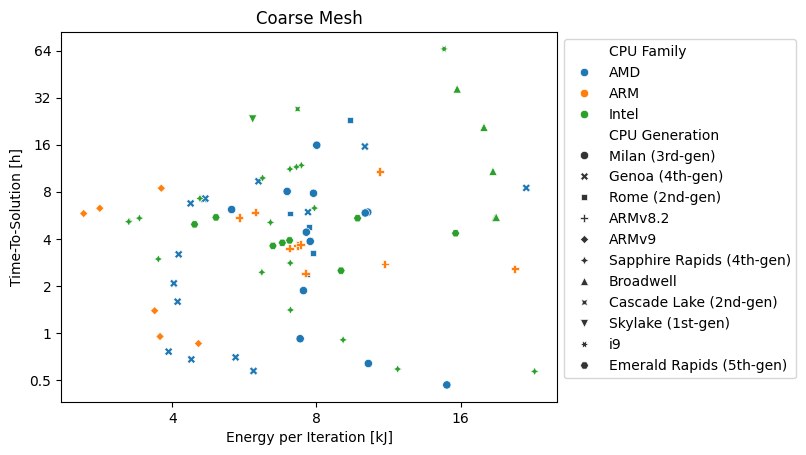

In [217]:
ax = sb.scatterplot(df_hw_coarse.sort_values("CPU Family"),x="Energy per Iteration [kJ]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", yscale="log", title="Coarse Mesh")
ax.set(ylabel="Time-To-Solution [h]")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()

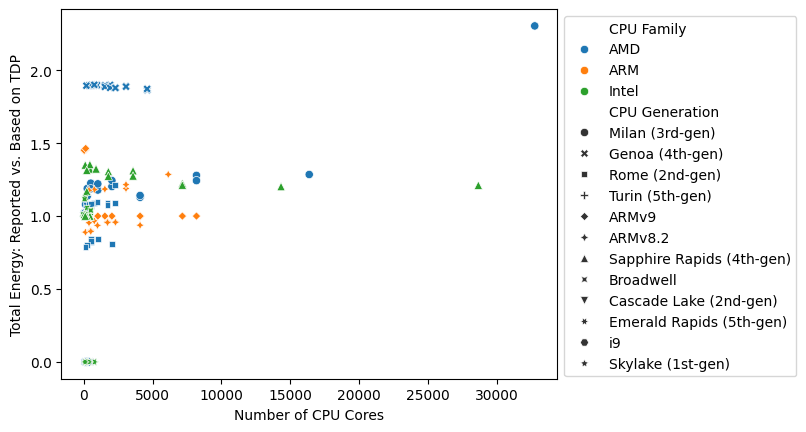

In [218]:
df_hardware["Measured-To-TDP-Energy Ratio"] = df_hardware["Run Consumed Energy [kWh]"] / df_hardware["Energy-To-Solution [kWh]"]
df = df_hardware
ax = sb.scatterplot(df.sort_values("CPU Family"),y="Measured-To-TDP-Energy Ratio", x="Number of CPU Cores", hue="CPU Family", style="CPU Generation")
ax.set(ylabel="Total Energy: Reported vs. Based on TDP")
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "Measured-To-TDP-Energy", doSaveFig)


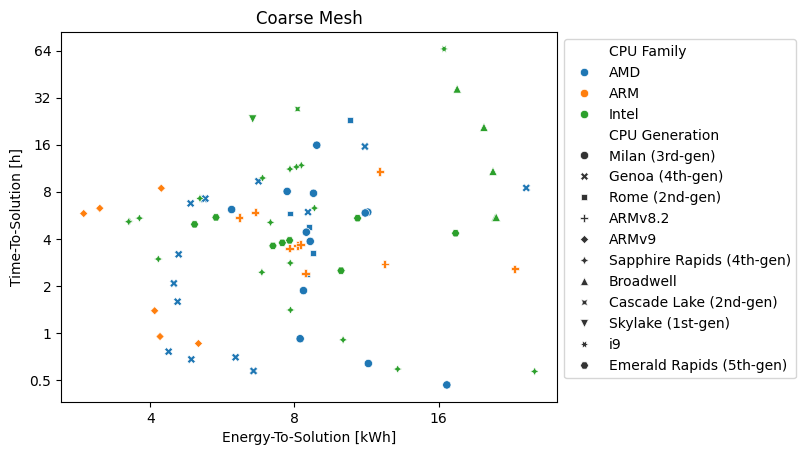

In [219]:

ax = sb.scatterplot(df_hw_coarse.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(title="Coarse Mesh")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2g'))
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_coarse", doSaveFig)

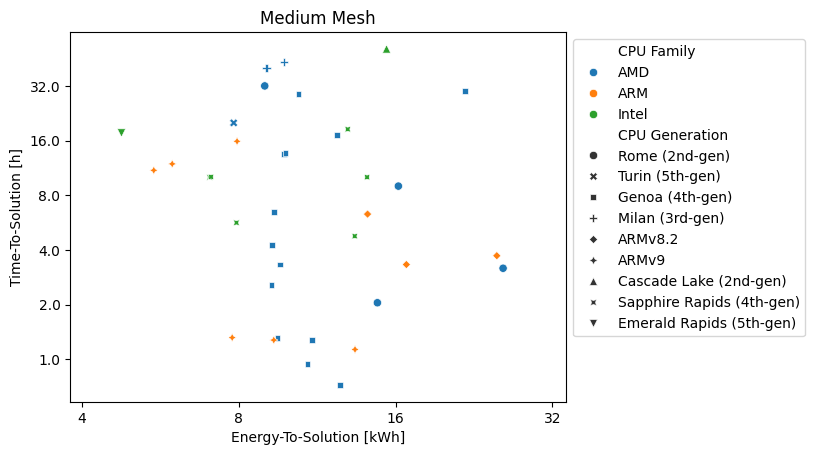

In [220]:

ax = sb.scatterplot(df_hw_medium.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(title="Medium Mesh", xlim=[3.8,34])
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_medium", doSaveFig)

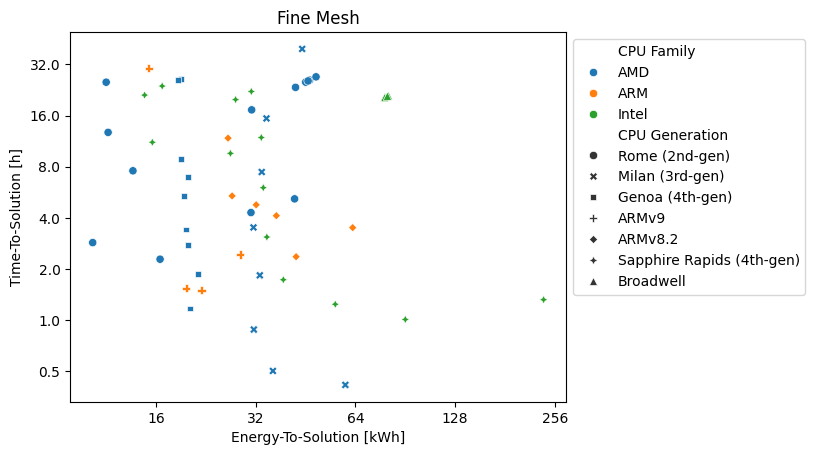

In [221]:

ax = sb.scatterplot(df_hw_fine.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(title="Fine Mesh")
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_fine", doSaveFig)

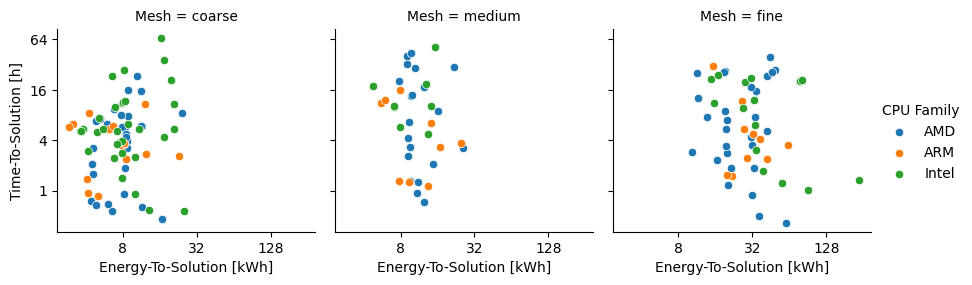

In [222]:
g = sb.FacetGrid(df_hardware.sort_values("CPU Family"), col="Mesh", hue="CPU Family", aspect=1.0, sharey=True, subplot_kws={"yscale":"log", "xscale":"log" }, col_order=["coarse","medium","fine"], legend_out=True)
g.map_dataframe(sb.scatterplot, y="Time-To-Solution [h]", x="Energy-To-Solution [kWh]")

#ax = sb.scatterplot(df_hardware,x="Number of CPU Cores", y="Run Wall-Clock Time [s]", hue="CPU Model", style="Mesh")
#ax.set(xscale="log", yscale="log", title=" Hardware Track")
g.add_legend()
# sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
for ax in g.axes.flat:
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
    ax.set_yscale("log", base=2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4g'))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_facetGrid", doSaveFig)

# Strong Scaling

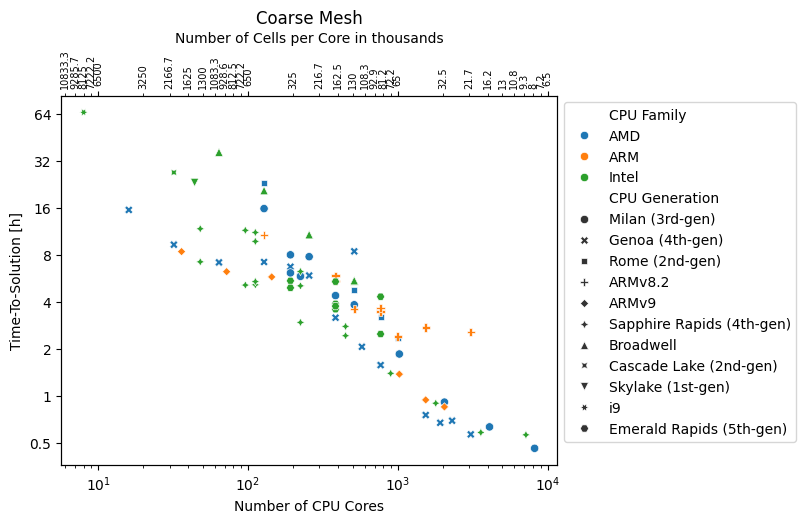

In [223]:
ax = sb.scatterplot(df_hw_coarse.sort_values("CPU Family"),x="Number of CPU Cores", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Coarse Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
addSecondaryAxisCellsPerCore(ax, size_coarse)
fig = ax.get_figure()

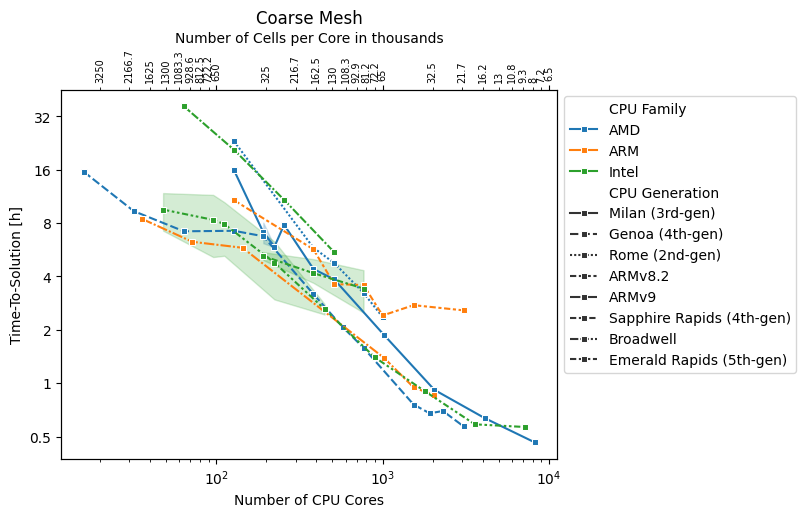

In [224]:
# Use only CPUs with more than one entry per submodel
df_hw_coarse_scaling = df_hw_coarse[df_hw_coarse.groupby("CPU Submodel")["CPU Submodel"].transform(len) > 2]
ax = sb.lineplot(df_hw_coarse_scaling.sort_values("CPU Family"), x="Number of CPU Cores", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation", marker='s', markersize=5)
ax.set(xscale="log", title="Coarse Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
addSecondaryAxisCellsPerCore(ax, size_coarse)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "strong_scaling_coarse", doSaveFig)

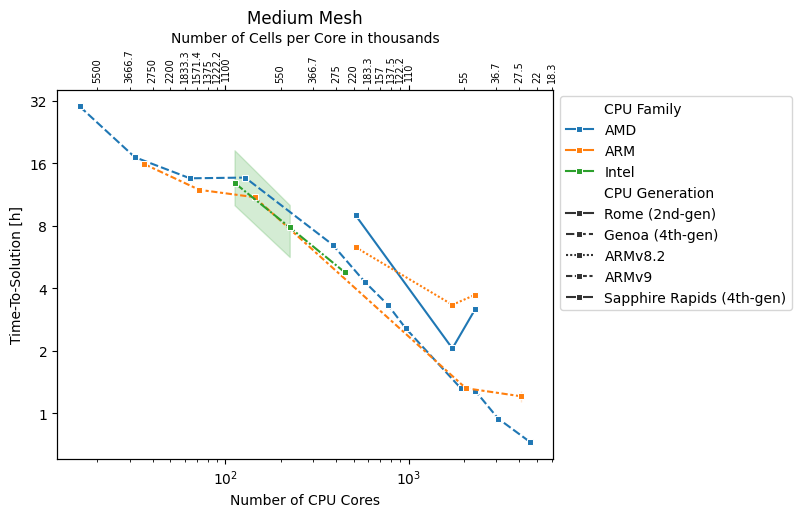

In [225]:
# Use only CPUs with more than one entry per submodel
df_hw_medium_scaling = df_hw_medium[df_hw_medium.groupby("CPU Submodel")["CPU Submodel"].transform(len) > 2]
ax = sb.lineplot(df_hw_medium_scaling.sort_values("CPU Family"), x="Number of CPU Cores", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation", marker='s', markersize=5)
ax.set(xscale="log", title="Medium Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
addSecondaryAxisCellsPerCore(ax, size_medium)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "strong_scaling_medium", doSaveFig)

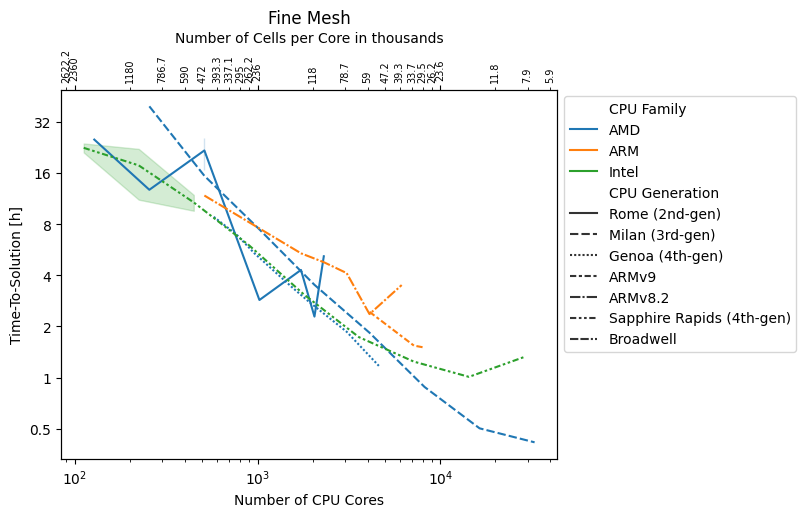

In [226]:
# Use only CPUs with more than one entry per submodel
df_hw_fine_scaling = df_hw_fine[df_hw_fine.groupby("CPU Submodel")["CPU Submodel"].transform(len) > 2]
ax = sb.lineplot(df_hw_fine_scaling.sort_values("CPU Family"), x="Number of CPU Cores", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Fine Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
addSecondaryAxisCellsPerCore(ax, size_fine)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "strong_scaling_fine", doSaveFig)

## Parallel Efficiency

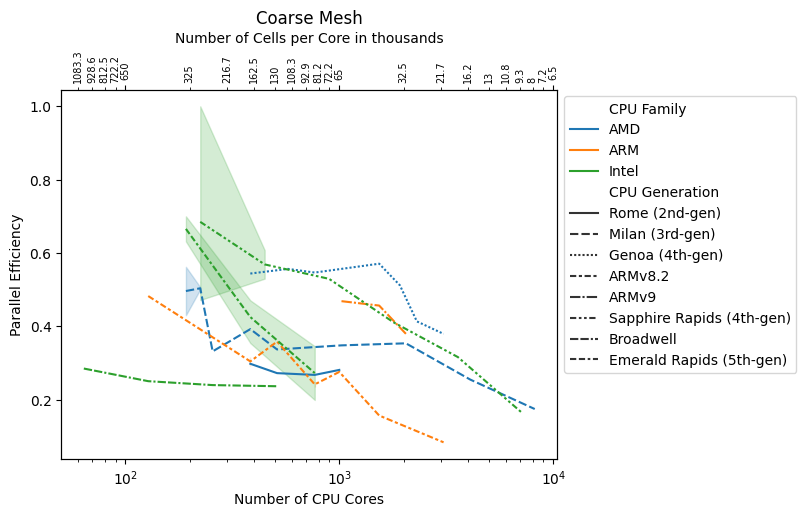

In [227]:
df = df_hw_coarse_scaling
df = df.reset_index(drop=True)
df = df[df["Number of Nodes"] > 1]
df["Total Core Time [s]"] = df["Time-To-Solution [h]"] * df["Number of CPU Cores"]
maxT_val = df["Total Core Time [s]"].min()
maxT_id = df["Total Core Time [s]"].idxmin()
df = df.assign(maxT=maxT_val)
df["Parallel Efficiency"] = df["maxT"] / df["Time-To-Solution [h]"] / df["Number of CPU Cores"]
ax = sb.lineplot(df.sort_values("CPU Model"), x="Number of CPU Cores", y="Parallel Efficiency", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Coarse Mesh")
addSecondaryAxisCellsPerCore(ax, size_coarse)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "parallel-efficiency_cores_coarse", doSaveFig)

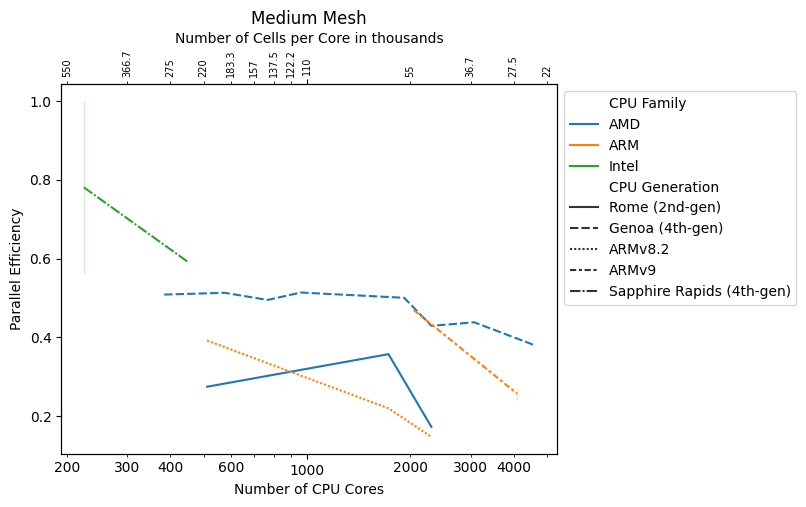

In [228]:
df = df_hw_medium_scaling
df = df.reset_index(drop=True)
df = df[df["Number of Nodes"] > 1]
df["Total Core Time [s]"] = df["Time-To-Solution [h]"] * df["Number of CPU Cores"]
maxT_val = df["Total Core Time [s]"].min()
maxT_id = df["Total Core Time [s]"].idxmin()
df = df.assign(maxT=maxT_val)
df["Parallel Efficiency"] = df["maxT"] / df["Time-To-Solution [h]"] / df["Number of CPU Cores"]
ax = sb.lineplot(df.sort_values("CPU Family"), x="Number of CPU Cores", y="Parallel Efficiency", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Medium Mesh")
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 1))
ax.xaxis.set_minor_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)
addSecondaryAxisCellsPerCore(ax, size_medium)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "parallel-efficiency_cores_medium", doSaveFig)

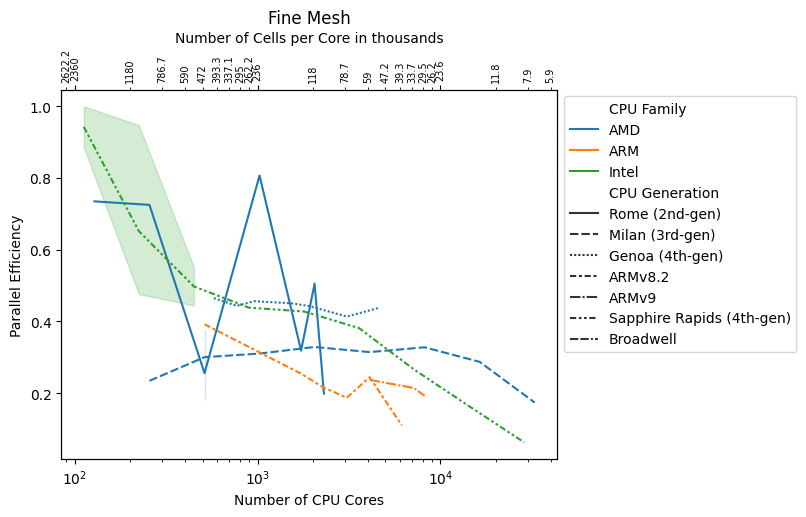

In [229]:
df = df_hw_fine_scaling
df = df.reset_index(drop=True)
df["Total Core Time [s]"] = df["Time-To-Solution [h]"] * df["Number of CPU Cores"]
maxT_val = df["Total Core Time [s]"].min()
maxT_id = df["Total Core Time [s]"].idxmin()
df = df.assign(maxT=maxT_val)
df["Parallel Efficiency"] = df["maxT"] / df["Time-To-Solution [h]"] / df["Number of CPU Cores"]
ax = sb.lineplot(df.sort_values("CPU Model"), x="Number of CPU Cores", y="Parallel Efficiency", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Fine Mesh")
addSecondaryAxisCellsPerCore(ax, size_fine)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "parallel-efficiency_cores_fine", doSaveFig)

## Single Node

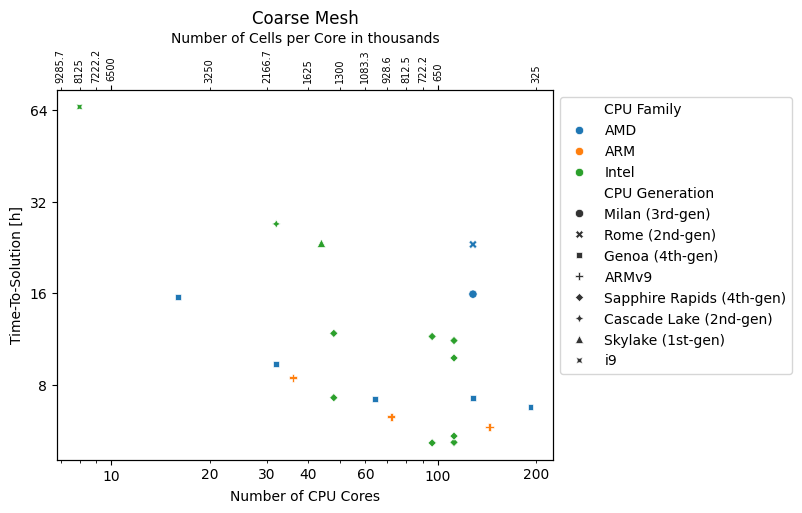

In [230]:
df = df_hw_coarse
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Number of CPU Cores", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Coarse Mesh")
ax.set_yscale("log", base=2)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1))
ax.xaxis.set_minor_formatter(formatter)
addSecondaryAxisCellsPerCore(ax, size_coarse)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

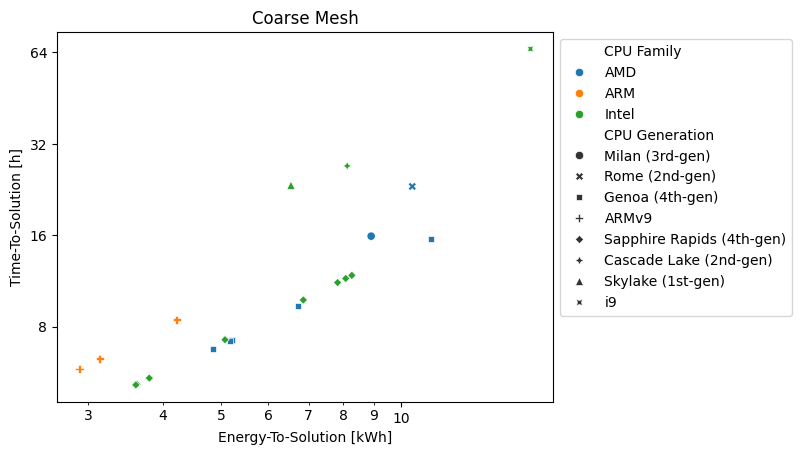

In [231]:
df = df_hw_coarse
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Coarse Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1))
ax.xaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

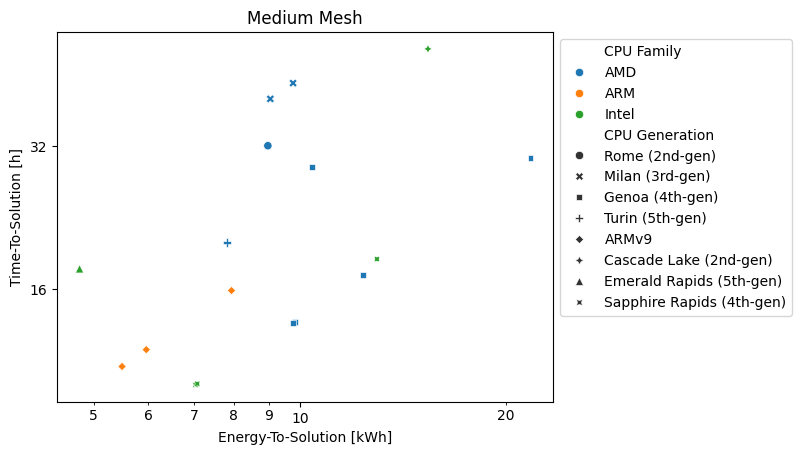

In [232]:
df = df_hw_medium
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.set(xscale="log", title="Medium Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 1))
ax.xaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

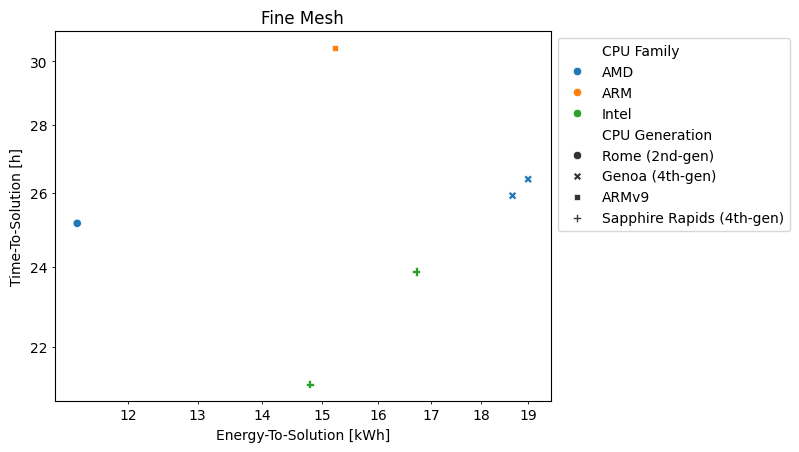

In [233]:
df = df_hw_fine
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="CPU Generation")
ax.minorticks_on()
ax.set(xscale="log", title="Fine Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1))
ax.xaxis.set_minor_formatter(formatter)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

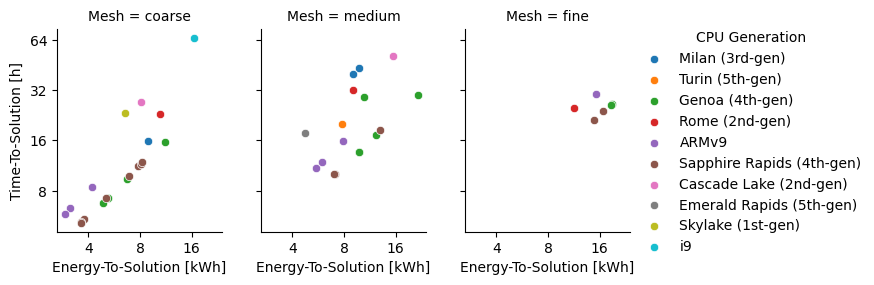

In [234]:
df = df_hardware
df = df[df["Number of Nodes"] == 1]
g = sb.FacetGrid(df.sort_values("CPU Family"), col="Mesh", hue="CPU Generation", aspect=0.75, sharey=True, subplot_kws={"yscale":"log", "xscale":"log" }, col_order=["coarse","medium","fine"], legend_out=True)
g.map_dataframe(sb.scatterplot, y="Time-To-Solution [h]", x="Energy-To-Solution [kWh]")
g.add_legend()
for ax in g.axes.flat:
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
    ax.set_yscale("log", base=2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4g'))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_facetGrid-singleNode", doSaveFig)

# Last-Level Cache

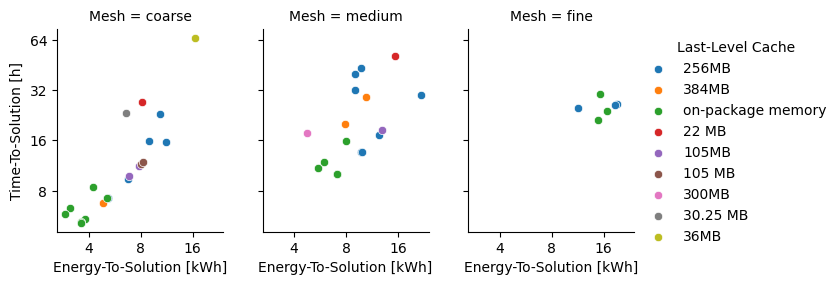

In [235]:
df = df_hardware
df = df[df["Number of Nodes"] == 1]
g = sb.FacetGrid(df.sort_values("CPU Family"), col="Mesh", hue="Last-Level Cache", aspect=0.75, sharey=True, subplot_kws={"yscale":"log", "xscale":"log" }, col_order=["coarse","medium","fine"], legend_out=True)
g.map_dataframe(sb.scatterplot, y="Time-To-Solution [h]", x="Energy-To-Solution [kWh]")
g.add_legend()
for ax in g.axes.flat:
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
    ax.set_yscale("log", base=2)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4g'))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "TTS_ETS_facetGrid-singleNode-Last-Level Cache", doSaveFig)

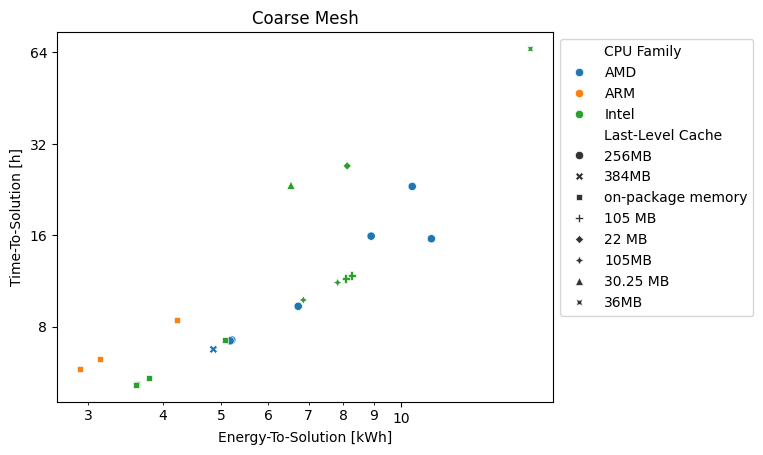

In [236]:
df = df_hw_coarse
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="Last-Level Cache")
ax.set(xscale="log", title="Coarse Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1))
ax.xaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "Last-Level Cache-singleNode-coarse", doSaveFig)

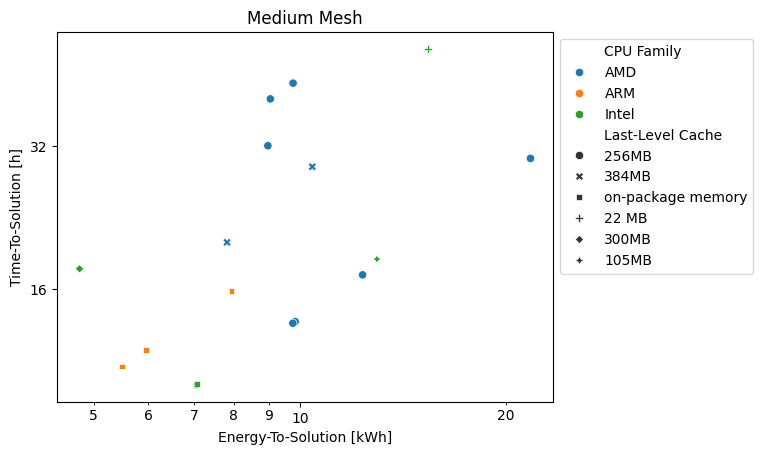

In [237]:
df = df_hw_medium
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="Last-Level Cache")
ax.set(xscale="log", title="Medium Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(3, 1))
ax.xaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "Last-Level Cache-singleNode-medium", doSaveFig)


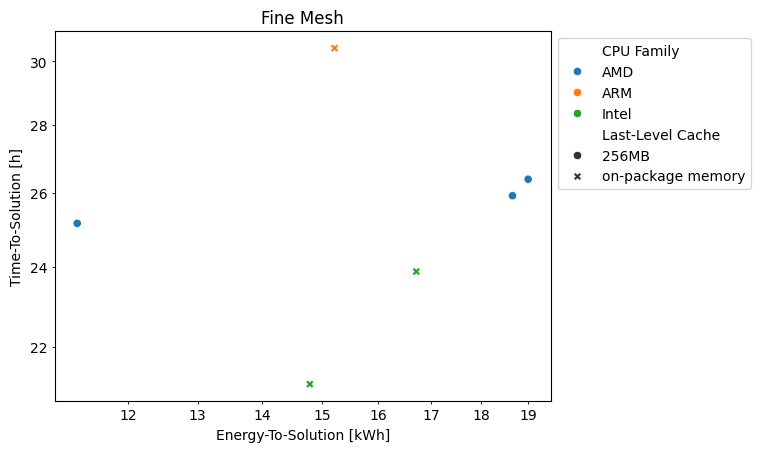

In [238]:
df = df_hw_fine
df = df[df["Number of Nodes"] == 1]
ax = sb.scatterplot(df.sort_values("CPU Family"),x="Energy-To-Solution [kWh]", y="Time-To-Solution [h]", hue="CPU Family", style="Last-Level Cache")
ax.minorticks_on()
ax.set(xscale="log", title="Fine Mesh")
ax.set_yscale("log", base=2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2g'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.4g'))
formatter = matplotlib.ticker.LogFormatter(labelOnlyBase=False, minor_thresholds=(2, 1))
ax.xaxis.set_minor_formatter(formatter)
ax.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(numticks=999, subs="auto"))
ax.yaxis.set_minor_formatter(formatter)
sb.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
fig = ax.get_figure()
op.save_fig(fig, fig_folder, "Last-Level Cache-singleNode-fine", doSaveFig)